## Neural networks: dependence of error and learning ability on the number of neurons

   In this activity, we will set up a two-layer neural network to solve a multi-class classification problem. It is proposed to perform the procedures of loading and splitting the input data, training the network, calculating the classification error and determination of the optimal number of neurons in the hidden layer of the network. 
    It is necessary to choose the number of neurons in such a way that, on the one hand, the model is simple, and on the other hand, it gives a fairly accurate forecast and does not retrain. 
    The purpose of the task is to show how the accuracy and learning ability of the network depend on its complexity.

To solve the problem of multiclass classification, it is proposed to use the library for building neural networks [pybrain](http://pybrain.org/). 

In [8]:
#pip install pybrain

Note: you may need to restart the kernel to use updated packages.


###  Dataset description

The problem of assessing the quality of wine by its physical and chemical properties is considered. [1]. This data is [open source](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) in the UCI repository and contain 1599 samples of red wine, described by 11 features, including acidity, percentage of sugar, alcohol, etc. In addition, each object is assigned a quality rating on a scale from 0 to 10. It is required to restore the wine quality rating according to the original description.

[1] P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties.  In Decision Support Systems, Elsevier, 47(4):547-553, 2009. 

In [1]:
%matplotlib inline

import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import numpy as np

Выполним загрузку данных

In [2]:
with open('winequality-red.csv') as f:
    f.readline()  # пропуск заголовочной строки
    data = np.loadtxt(f, delimiter=';')

In [3]:
data

array([[ 7.4  ,  0.7  ,  0.   , ...,  0.56 ,  9.4  ,  5.   ],
       [ 7.8  ,  0.88 ,  0.   , ...,  0.68 ,  9.8  ,  5.   ],
       [ 7.8  ,  0.76 ,  0.04 , ...,  0.65 ,  9.8  ,  5.   ],
       ...,
       [ 6.3  ,  0.51 ,  0.13 , ...,  0.75 , 11.   ,  6.   ],
       [ 5.9  ,  0.645,  0.12 , ...,  0.71 , 10.2  ,  5.   ],
       [ 6.   ,  0.31 ,  0.47 , ...,  0.66 , 11.   ,  6.   ]])

Alternatively, we can download data directly from the UCI repository using the urllib library.

In [4]:
#import urllib
# URL for the Wine Quality Data Set (UCI Machine Learning Repository)
#url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
# загрузка файла
#f = urllib.urlopen(url)
#f.readline()  # пропуск заголовочной строки
#data = np.loadtxt(f, delimiter=';')

Let's extract the target variable from the data. The classes in the data are unbalanced: the main share of objects is given a quality score from 5 to 7. Let's reduce the problem to a three-class one: we will give a score of 5 to objects with a quality score of less than five, and a score of 7 to objects with a quality score of more than seven.

In [5]:
TRAIN_SIZE = 0.7 # Splitting the data in train and test 70/30%

#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

y = data[:, -1]
np.place(y, y < 5, 5)
np.place(y, y > 7, 7)
y -= min(y)
X = data[:, :-1]
X = normalize(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_SIZE, random_state=0)

### Two-layer neural network

A two-layer neural network is a recognition function that can be written as the following superposition:

$f(x,W)=h^{(2)}\left(\sum\limits_{i=1}^D w_i^{(2)}h^{(1)}\left(\sum\limits_{j=1}^n w_{ji}^{(1)}x_j+b_i^{(1)}\right)+b^{(2)}\right)$, где

$x$ -- original object (wine variety described by 11 attributes), $x_j$ -- corresponding feature,

$n$ --  the number of neurons in the input layer of the network, coinciding with the number of features,

$D$ --  the number of neurons in the hidden layer of the network,

$w_i^{(2)}, w_{ji}^{(1)}, b_i^{(1)}, b^{(2)}$ --  network parameters corresponding to the weights of neurons,

$h^{(1)}, h^{(2)}$ -- activation functions.

A linear function is used as an activation function on the hidden layer of the network. At the output layer of the network, the softmax activation function is used, which is a generalization of the sigmoid function for the multiclass case:

$y_k=\text{softmax}_k(a_1,...,a_k)=\frac{\exp(a_k)}{\sum_{k=1}^K\exp(a_k)}.$



### Configuring network settings

Optimal network settings $W_{opt}$ are determined by minimizing the error function:

$W_{opt}=\arg\min\limits_{W}L(W)+\lambda\|W\|^2$.

Here $L(W)$ is a function of the multiclass classification error,

$L(W)=- \sum^N_{n=1}\sum^K_{k=1} t_{kn} log(y_{kn}),$

$t_{kn}$ -- binary encoded class labels, $K$ -- number of labels, $N$ -- number of objects,

а $\lambda\|W\|^2$ is a regularizing term that controls the total weight of the network parameters and prevents the overfitting effect.

Parameter optimization is performed using the backpropagation method.

Let's load the main modules: ClassificationDataSet - pybrain data structure, buildNetwork - neural network initialization, BackpropTrainer - optimization of network parameters using the backpropagation method, SoftmaxLayer - softmax function corresponding to the output layer of the network, percentError - function for calculating the classification error (percentage of incorrect answers ).

In [6]:
from pybrain.datasets import ClassificationDataSet # Структура данных pybrain
from pybrain.tools.shortcuts import buildNetwork
from pybrain.supervised.trainers import BackpropTrainer
from pybrain.structure.modules import SoftmaxLayer
from pybrain.utilities import percentError

We initialize the main parameters of the task: HIDDEN_NEURONS_NUM -- the number of neurons in the hidden layer, MAX_EPOCHS -- the maximum number of iterations of the optimization algorithm

In [7]:
HIDDEN_NEURONS_NUM = 100
MAX_EPOCHS = 100

We initialize the ClassificationDataSet data structure used by the pybrain library. For initialization, the structure takes two arguments: the number of features *np.shape(X)[1]* and the number of different class labels *len(np.unique(y))*.

In addition, we will binarize the target variable using the *_convertToOneOfMany( )* function and split the data into training and test parts.

In [8]:
# ClassificationDataSet
# Train
ds_train = ClassificationDataSet(np.shape(X)[1], nb_classes=len(np.unique(y_train)))

ds_train.setField('input', X_train) 
ds_train.setField('target', y_train[:, np.newaxis]) 
ds_train._convertToOneOfMany( ) 
# Test
ds_test = ClassificationDataSet(np.shape(X)[1], nb_classes=len(np.unique(y_train)))
ds_test.setField('input', X_test)
ds_test.setField('target', y_test[:, np.newaxis])
ds_test._convertToOneOfMany( )

We initialize a two-layer network and optimize its parameters. Arguments for initialization are:

ds.indim -- the number of neurons in the input layer of the network, the same as the number of features (in our case 11),

HIDDEN_NEURONS_NUM -- number of neurons in the hidden layer of the network,

ds.outdim -- the number of neurons in the output layer of the network, the same as the number of different class labels (in our case 3),

SoftmaxLayer is the softmax function used on the output layer to solve the multiclass classification problem.

In [9]:
np.random.seed(0) # Fix seed 

#  (Feedforward network)
net = buildNetwork(ds_train.indim, HIDDEN_NEURONS_NUM, ds_train.outdim, outclass=SoftmaxLayer)


init_params = np.random.random((len(net.params))) 
net._setParameters(init_params)

 Let's optimize the network parameters. The graph below shows the convergence of the error function on the training/control part.

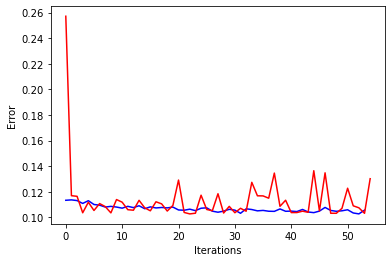

In [10]:
random.seed(0)
# pybrain uses random; let's fix seed 
trainer = BackpropTrainer(net, dataset=ds_train) 
err_train, err_val = trainer.trainUntilConvergence(maxEpochs=MAX_EPOCHS)
line_train = plt.plot(err_train, 'b', err_val, 'r')
xlab = plt.xlabel('Iterations')
ylab = plt.ylabel('Error')

Let us calculate the value of the proportion of incorrect answers in the training and control samples.

In [11]:
res_train = net.activateOnDataset(ds_train).argmax(axis=1) 
print ('Error on train: ', percentError(res_train, ds_train['target'].argmax(axis=1)), '%') 
res_test = net.activateOnDataset(ds_test).argmax(axis=1) 
print ('Error on test: ', percentError(res_test, ds_test['target'].argmax(axis=1)), '%') 

Error on train:  51.29579982126899 %
Error on test:  46.666666666666664 %


### Task. Determination of the optimal number of neurons.
In the task, it is required to investigate the dependence of the error on the control sample depending on the number of neurons in the hidden layer of the network. The number of neurons for which it is supposed to enumerate is written in the vector
```
hidden_neurons_num = [50, 100, 200, 500, 700, 1000]
```


train:  [47.899910634495086, 44.32529043789098, 43.52100089365505, 39.94638069705094, 42.0017873100983, 41.19749776586238] test [43.125, 41.041666666666664, 42.083333333333336, 37.708333333333336, 35.0, 35.625]
min= 35.0 neyrons: = 700


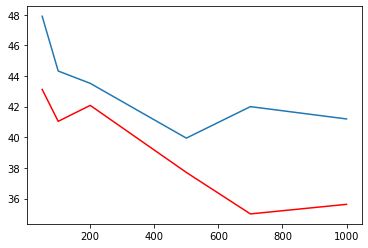

In [15]:
random.seed(0) 
np.random.seed(0)

from pybrain.structure.modules import LinearLayer

def plot_classification_error(hidden_neurons_num, res_train_vec, res_test_vec):

    plt.figure()
    plt.plot(hidden_neurons_num, res_train_vec)
    plt.plot(hidden_neurons_num, res_test_vec, '-r')

def write_answer_nn(optimal_neurons_num):
    with open("nnets_answer1.txt", "w") as fout:
        fout.write(str(optimal_neurons_num))

hidden_neurons_num = [50, 100, 200, 500, 700, 1000]
res_train_vec = list()
res_test_vec = list()

for nnum in hidden_neurons_num:
    
    net = buildNetwork(ds_train.indim, nnum, ds_train.outdim, outclass=SoftmaxLayer, hiddenclass = LinearLayer)
    
    init_params = np.random.random((len(net.params))) 
    net._setParameters(init_params)
    trainer = BackpropTrainer(net, dataset=ds_train) 
    err_train, err_val = trainer.trainUntilConvergence(maxEpochs=MAX_EPOCHS)
    
    res_train = net.activateOnDataset(ds_train).argmax(axis=1) # result on train
    res_train_vec.append(percentError(res_train, ds_train['target'].argmax(axis=1))) # train error
    res_test = net.activateOnDataset(ds_test).argmax(axis=1) # result on test
    res_test_vec.append(percentError(res_test, ds_test['target'].argmax(axis=1))) # test error
    
# Plot training and control errors versus number of neurons
plot_classification_error(hidden_neurons_num, res_train_vec, res_test_vec)          
#  min error calculation and corresponding amount of neurons
write_answer_nn(hidden_neurons_num[res_test_vec.index(min(res_test_vec))]) 

print("train: ", res_train_vec, "test", res_test_vec)
print('min=', min(res_test_vec), 'neyrons: =', hidden_neurons_num[res_test_vec.index(min(res_test_vec))])